In [7]:
!pip install --quiet yfinance gym==0.25.2 torch torchvision torchaudio pandas numpy matplotlib

# %%
import yfinance as yf
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, namedtuple
import random


#TEST 1 ONLY CHANGING THE INDICATORS AND REWARD FUNCTION
#MAIN CODE

In [2]:
def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df

# %%
def add_indicators(df, window_sma=10, window_ema=10, window_rsi=14, macd_fast=12, macd_slow=26, macd_signal=9, adx_period=18):
    """
    Add multiple technical indicators to a DataFrame

    Parameters:
    - df: DataFrame with OHLCV data (Open, High, Low, Close, Volume)
    - window_sma: Simple Moving Average window
    - window_ema: Exponential Moving Average window
    - window_rsi: RSI calculation window
    - macd_fast: MACD fast EMA period
    - macd_slow: MACD slow EMA period
    - macd_signal: MACD signal line EMA period
    - adx_period: ADX calculation period
    """

    # Simple Moving Average
    #df['SMA'] = df['Close'].rolling(window=window_sma).mean()

    # Exponential Moving Average
    #df['EMA'] = df['Close'].ewm(span=window_ema, adjust=False).mean()

    # RSI calculation
    #delta = df['Close'].diff()
    #gain = delta.where(delta > 0, 0).rolling(window=window_rsi).mean()
    #loss = -delta.where(delta < 0, 0).rolling(window=window_rsi).mean()
    #rs = gain / loss
    #df['RSI'] = 100 - (100 / (1 + rs))

    # MACD calculation
    ema_fast = df['Close'].ewm(span=macd_fast).mean()
    ema_slow = df['Close'].ewm(span=macd_slow).mean()
    df['MACD'] = ema_fast - ema_slow
    df['MACD_Signal'] = df['MACD'].ewm(span=macd_signal).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

    # Accumulation/Distribution Line
    # A/D Line = Previous A/D + Money Flow Volume
    # Money Flow Volume = Volume * ((Close - Low) - (High - Close)) / (High - Low)
    money_flow_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    money_flow_volume = money_flow_multiplier * df['Volume']
    df['AD_Line'] = money_flow_volume.cumsum()

    # ADX calculation (Average Directional Index)
    # Calculate True Range (TR)
    df['H_L'] = df['High'] - df['Low']
    df['H_PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L_PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H_L', 'H_PC', 'L_PC']].max(axis=1)

    # Calculate Directional Movement (+DM and -DM)
    df['H_diff'] = df['High'] - df['High'].shift(1)
    df['L_diff'] = df['Low'].shift(1) - df['Low']

    df['DM_pos'] = df['H_diff'].where((df['H_diff'] > df['L_diff']) & (df['H_diff'] > 0), 0)
    df['DM_neg'] = df['L_diff'].where((df['L_diff'] > df['H_diff']) & (df['L_diff'] > 0), 0)

    # Calculate smoothed TR, +DM, and -DM
    df['TR_smooth'] = df['TR'].rolling(window=adx_period).mean()
    df['DM_pos_smooth'] = df['DM_pos'].rolling(window=adx_period).mean()
    df['DM_neg_smooth'] = df['DM_neg'].rolling(window=adx_period).mean()

    # Calculate Directional Indicators (+DI and -DI)
    df['DI_pos'] = 100 * (df['DM_pos_smooth'] / df['TR_smooth'])
    df['DI_neg'] = 100 * (df['DM_neg_smooth'] / df['TR_smooth'])

    # Calculate DX and ADX
    df['DX'] = 100 * abs(df['DI_pos'] - df['DI_neg']) / (df['DI_pos'] + df['DI_neg'])
    df['ADX'] = df['DX'].rolling(window=adx_period).mean()

    # Clean up intermediate columns
    df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
             'TR_smooth', 'DM_pos_smooth', 'DM_neg_smooth', 'DX'], axis=1, inplace=True)

    # Back-fill NaN values
    df.bfill(inplace=True)

    return df

# %%
class TradingEnv(gym.Env):
    """Custom Gym environment for single-stock trading"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)
        self.past_returns = deque(maxlen=20)  # Initialize past returns with a window of 20
        # Actions: 0 = hold, 1 = buy 1 share, 2 = sell 1 share
        self.action_space = spaces.Discrete(3)
        # Observation: [close, MACD_Signal, MACD, ADX,A/D Line, holdings, cash]
        obs_low = np.array([0, 0, -np.inf, 0, -np.inf, 0 ,0], dtype=np.float32)
        obs_high = np.array([np.inf, np.inf, np.inf, 100, np.inf, np.inf, np.inf], dtype=np.float32) # Adjusted upper bound for indicators
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        return self._get_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        # Ensure all required columns exist before accessing
        required_cols = ['Close', 'MACD', 'MACD_Signal', 'ADX', 'AD_Line'] # Added OBV as it's used later
        for col in required_cols:
            if col not in row.index:
                # Handle missing columns, maybe return a default observation or raise an error
                print(f"Warning: Column '{col}' not found in data at step {self.current_step}. Using 0.0")
                # Depending on your needs, you might want to handle this differently
                # For now, we'll use a placeholder value
                row[col] = 0.0

        return np.array([
            row['Close'].item(),
            row['MACD_Signal'].item(),
            row['MACD'].item(),
            row['ADX'].item(),
            row['AD_Line'].item(),
            float(self.shares_held),
            float(self.balance)
        ], dtype=np.float32)

    def step(self, action):
      row = self.df.loc[self.current_step]
      price = row['Close'].item()
      prev_net_worth = self.net_worth

      # Execute action
      if action == 1:  # buy
        if self.balance >= price:
            self.shares_held += 1
            self.balance -= price
      elif action == 2:  # sell
        if self.shares_held > 0:
            self.shares_held -= 1
            self.balance += price

      self.current_step += 1
      done = self.current_step >= self.max_steps
      row_next = self.df.loc[self.current_step]
      self.net_worth = self.balance + self.shares_held * row_next['Close'].item()

    # Calculate relative return
      if prev_net_worth > 0:
        relative_return = (self.net_worth - prev_net_worth) / prev_net_worth
      else:
        relative_return = 0

    # Calculate standard deviation of past returns (excluding current return)
      if len(self.past_returns) >= 2:
        std_returns = np.std(self.past_returns)
      else:
        std_returns = 0

    # Define reward with risk adjustment
      epsilon = 1e-6
      if std_returns > 0:
        reward = relative_return / std_returns
      else:
        reward = relative_return / epsilon

    # Append current return to past_returns after calculating reward
      self.past_returns.append(relative_return)

      obs = self._get_obs()
      return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")


# %%
class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# %%
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)



# %%
# Hyperparameters
episode_count = 50
nb_steps = 200
gamma = 0.99
epsilon_start = 1.0
epsilon_end = 0.01
epsilon_decay = 500
batch_size = 64
target_update = 10

# Fetch and prepare data
df = fetch_data('AAPL', '2020-01-01', '2021-01-01')
df = add_indicators(df)

env = TradingEnv(df, initial_balance=10000, max_steps=200)

# Init networks and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
memory = ReplayBuffer()

steps_done = 0

def select_action(state):
    global steps_done
    eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps_threshold:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        state_v = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = policy_net(state_v)
        return q_values.argmax().item()

for episode in range(1, episode_count + 1):
    state = env.reset()
    total_reward = 0
    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Learn from experience
        if len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            state_batch = torch.tensor(batch.state, dtype=torch.float32).to(device)
            action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
            next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32).to(device)
            done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

            q_values = policy_net(state_batch).gather(1, action_batch)
            next_q_values = target_net(next_state_batch).max(1)[0].detach().unsqueeze(1)
            expected_q = reward_batch + (gamma * next_q_values * (1 - done_batch))

            loss = nn.MSELoss()(q_values, expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if done:
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
    print(f"Episode {episode}/{episode_count}, Total Reward: {total_reward:.2f}")



# %%
state = env.reset()
values = []
s = state
for _ in range(env.max_steps):
    action = policy_net(
        torch.tensor(s, dtype=torch.float32)
               .unsqueeze(0).to(device)
    ).argmax().item()
    s, _, done, _ = env.step(action)
    values.append(env.net_worth)
    if done:
        break

# Generate buy‑and‑hold values for the same number of steps:
bh_prices = df['Close'].iloc[:len(values)].values
bh_values  = bh_prices / bh_prices[0] * env.initial_balance

# Plot both on a shared 0–N axis:
plt.figure(figsize=(10, 5))
plt.plot(range(len(values)), values, label='DQN Portfolio Value')
plt.plot(range(len(bh_values)), bh_values, label='Buy and Hold')
plt.legend()
plt.title('Portfolio Value Over Time (aligned steps)')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.show()




# ## End of Notebook
# You can now experiment with parameters, different stocks, or add more indicators!

/tmp/ipython-input-2-1776412408.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2-1776412408.py:77: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


KeyboardInterrupt: 

#CODE 2 CHANGING BOTH INDICATORS AND REWARD FUNCTION AND MODEL TO DRQN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-8-918322295.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Episode 1/15, Total Reward: 125.50
Episode 2/15, Total Reward: 25.39
Episode 3/15, Total Reward: 25.57
Episode 4/15, Total Reward: -6.09
Episode 5/15, Total Reward: 38.17
Episode 6/15, Total Reward: 91.63
Episode 7/15, Total Reward: 24.21
Episode 8/15, Total Reward: 25.56
Episode 9/15, Total Reward: 25.22
Episode 10/15, Total Reward: 201.47
Episode 11/15, Total Reward: 24.90
Episode 12/15, Total Reward: 25.49
Episode 13/15, Total Reward: 24.28
Episode 14/15, Total Reward: 26.07
Episode 15/15, Total Reward: 24.38


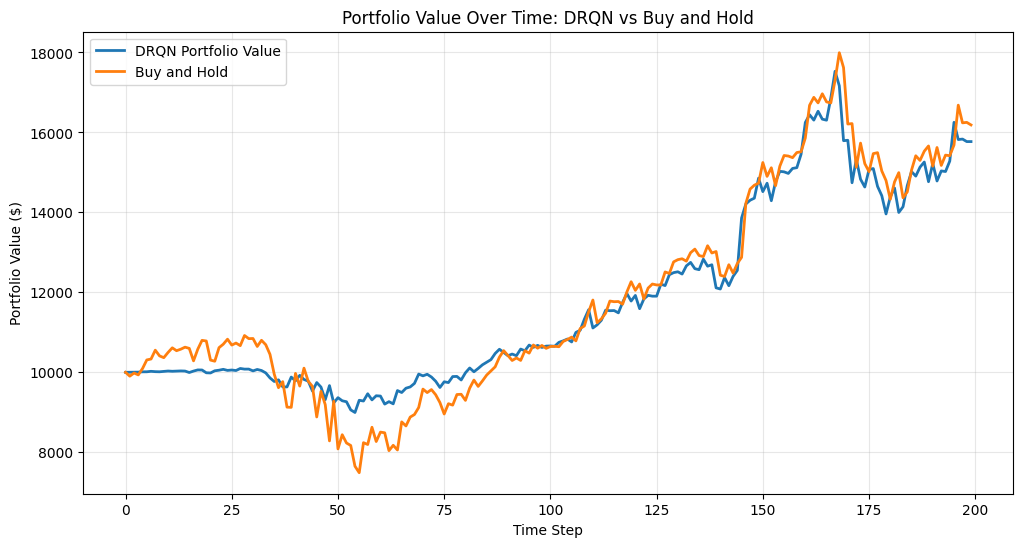


Final Results:
DRQN Final Value: $15770.62


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [8]:
def fetch_data(symbol, start_date, end_date):
    df = yf.download(symbol, start=start_date, end=end_date)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    return df

def add_indicators(df, window_sma=30, window_ema=10, window_rsi=21, macd_fast=18, macd_slow=26, macd_signal=9, adx_period=28):
    """
    Add multiple technical indicators to a DataFrame

    Parameters:
    - df: DataFrame with OHLCV data (Open, High, Low, Close, Volume)
    - window_sma: Simple Moving Average window
    - window_ema: Exponential Moving Average window
    - window_rsi: RSI calculation window
    - macd_fast: MACD fast EMA period
    - macd_slow: MACD slow EMA period
    - macd_signal: MACD signal line EMA period
    - adx_period: ADX calculation period
    """

    # MACD calculation
    ema_fast = df['Close'].ewm(span=macd_fast).mean()
    ema_slow = df['Close'].ewm(span=macd_slow).mean()
    df['MACD'] = ema_fast - ema_slow
    df['MACD_Signal'] = df['MACD'].ewm(span=macd_signal).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

    # Accumulation/Distribution Line
    money_flow_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])
    money_flow_volume = money_flow_multiplier * df['Volume']
    df['AD_Line'] = money_flow_volume.cumsum()

    # ADX calculation (Average Directional Index)
    # Calculate True Range (TR)
    df['H_L'] = df['High'] - df['Low']
    df['H_PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L_PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H_L', 'H_PC', 'L_PC']].max(axis=1)

    # Calculate Directional Movement (+DM and -DM)
    df['H_diff'] = df['High'] - df['High'].shift(1)
    df['L_diff'] = df['Low'].shift(1) - df['Low']

    df['DM_pos'] = df['H_diff'].where((df['H_diff'] > df['L_diff']) & (df['H_diff'] > 0), 0)
    df['DM_neg'] = df['L_diff'].where((df['L_diff'] > df['H_diff']) & (df['L_diff'] > 0), 0)

    # Calculate smoothed TR, +DM, and -DM
    df['TR_smooth'] = df['TR'].rolling(window=adx_period).mean()
    df['DM_pos_smooth'] = df['DM_pos'].rolling(window=adx_period).mean()
    df['DM_neg_smooth'] = df['DM_neg'].rolling(window=adx_period).mean()

    # Calculate Directional Indicators (+DI and -DI)
    df['DI_pos'] = 100 * (df['DM_pos_smooth'] / df['TR_smooth'])
    df['DI_neg'] = 100 * (df['DM_neg_smooth'] / df['TR_smooth'])

    # Calculate DX and ADX
    df['DX'] = 100 * abs(df['DI_pos'] - df['DI_neg']) / (df['DI_pos'] + df['DI_neg'])
    df['ADX'] = df['DX'].rolling(window=adx_period).mean()

    # Clean up intermediate columns
    df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
             'TR_smooth', 'DM_pos_smooth', 'DM_neg_smooth', 'DX'], axis=1, inplace=True)

    # Back-fill NaN values
    df.bfill(inplace=True)

    return df

class TradingEnv(gym.Env):
    """Custom Gym environment for single-stock trading with sequence support for DRQN"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df, initial_balance=10000, max_steps=200, sequence_length=10):
        super(TradingEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.max_steps = min(max_steps, len(df) - 1)
        self.sequence_length = sequence_length
        self.past_returns = deque(maxlen=20)

        # Actions: 0 = hold, 1 = buy 1 share, 2 = sell 1 share
        self.action_space = spaces.Discrete(3)

        # Observation: [close, MACD_Signal, MACD, ADX, A/D Line, holdings, cash]
        obs_low = np.array([0, 0, -np.inf, 0, -np.inf, 0, 0], dtype=np.float32)
        obs_high = np.array([np.inf, np.inf, np.inf, 100, np.inf, np.inf, np.inf], dtype=np.float32)
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

        # Store observation history for sequences
        self.observation_history = deque(maxlen=sequence_length)

    def reset(self):
        self.balance = float(self.initial_balance)
        self.net_worth = float(self.initial_balance)
        self.shares_held = 0
        self.current_step = 0
        self.observation_history.clear()

        # Initialize observation history with the first observation
        initial_obs = self._get_obs()
        for _ in range(self.sequence_length):
            self.observation_history.append(initial_obs)

        return self._get_sequence_obs()

    def _get_obs(self):
        row = self.df.loc[self.current_step]
        required_cols = ['Close', 'MACD', 'MACD_Signal', 'ADX', 'AD_Line']
        for col in required_cols:
            if col not in row.index:
                print(f"Warning: Column '{col}' not found in data at step {self.current_step}. Using 0.0")
                row[col] = 0.0

        return np.array([
            row['Close'].item(),
            row['MACD_Signal'].item(),
            row['MACD'].item(),
            row['ADX'].item(),
            row['AD_Line'].item(),
            float(self.shares_held),
            float(self.balance)
        ], dtype=np.float32)

    def _get_sequence_obs(self):
        """Return the sequence of observations for DRQN"""
        return np.array(list(self.observation_history), dtype=np.float32)

    def step(self, action):
        row = self.df.loc[self.current_step]
        price = row['Close'].item()
        prev_net_worth = self.net_worth

        # Execute action
        if action == 1:  # buy
            if self.balance >= price:
                self.shares_held += 1
                self.balance -= price
        elif action == 2:  # sell
            if self.shares_held > 0:
                self.shares_held -= 1
                self.balance += price

        self.current_step += 1
        done = self.current_step >= self.max_steps

        if not done:
            row_next = self.df.loc[self.current_step]
            self.net_worth = self.balance + self.shares_held * row_next['Close'].item()
        else:
            self.net_worth = self.balance + self.shares_held * price

        # Calculate reward
        if prev_net_worth > 0:
            relative_return = (self.net_worth - prev_net_worth) / prev_net_worth
        else:
            relative_return = 0

        if len(self.past_returns) >= 2:
            std_returns = np.std(self.past_returns)
        else:
            std_returns = 0

        epsilon = 1e-6
        if std_returns > 0:
            reward = relative_return / std_returns
        else:
            reward = relative_return / epsilon

        self.past_returns.append(relative_return)

        # Update observation history
        if not done:
            new_obs = self._get_obs()
            self.observation_history.append(new_obs)

        obs = self._get_sequence_obs()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f"Step: {self.current_step}, Balance: {self.balance:.2f}, Shares: {self.shares_held}, Net Worth: {self.net_worth:.2f}")

class DRQN(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dim=256, num_layers=2):
        super(DRQN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x, hidden=None):
        # x shape: (batch_size, sequence_length, input_dim)
        lstm_out, hidden = self.lstm(x, hidden)

        # Use the last output of the sequence
        last_output = lstm_out[:, -1, :]

        # Pass through fully connected layers
        x = torch.relu(self.fc1(last_output))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x, hidden

    def init_hidden(self, batch_size, device):
        """Initialize hidden state for LSTM"""
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        return (h0, c0)

# Modified Transition to include sequences
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Hyperparameters
episode_count = 15
nb_steps = 300
sequence_length = 5
gamma = 0.999
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 200
batch_size = 64  # Reduced batch size for sequences
target_update = 20

# Fetch and prepare data
df = fetch_data('AAPL', '2020-01-01', '2021-01-01')
df = add_indicators(df)

env = TradingEnv(df, initial_balance=10000, max_steps=200, sequence_length=sequence_length)

# Initialize networks and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
policy_net = DRQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net = DRQN(env.observation_space.shape[0], env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(policy_net.parameters(), lr=1e-2)
memory = ReplayBuffer()

steps_done = 0

def select_action(state):
    global steps_done
    eps_threshold = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if random.random() < eps_threshold:
        return random.randrange(env.action_space.n)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values, _ = policy_net(state_tensor)
        return q_values.argmax().item()

# Training loop
for episode in range(1, episode_count + 1):
    state = env.reset()
    total_reward = 0

    for t in range(nb_steps):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        memory.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        # Learn from experience
        if len(memory) >= batch_size:
            transitions = memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            # Convert to tensors
            state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32).to(device)
            action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
            reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
            next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float32).to(device)
            done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

            # Forward pass through networks
            q_values, _ = policy_net(state_batch)
            q_values = q_values.gather(1, action_batch)

            with torch.no_grad():
                next_q_values, _ = target_net(next_state_batch)
                next_q_values = next_q_values.max(1)[0].detach().unsqueeze(1)

            expected_q = reward_batch + (gamma * next_q_values * (1 - done_batch))

            # Compute loss and update
            loss = nn.MSELoss()(q_values, expected_q)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)  # Gradient clipping
            optimizer.step()

        if done:
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    print(f"Episode {episode}/{episode_count}, Total Reward: {total_reward:.2f}")

# Evaluation
policy_net.eval()
state = env.reset()
values = []
s = state

for _ in range(env.max_steps):
    with torch.no_grad():
        state_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0).to(device)
        q_values, _ = policy_net(state_tensor)
        action = q_values.argmax().item()

    s, _, done, _ = env.step(action)
    values.append(env.net_worth)
    if done:
        break

# Generate buy-and-hold values for comparison
bh_prices = df['Close'].iloc[:len(values)].values
bh_values = bh_prices / bh_prices[0] * env.initial_balance

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(len(values)), values, label='DRQN Portfolio Value', linewidth=2)
plt.plot(range(len(bh_values)), bh_values, label='Buy and Hold', linewidth=2)
plt.legend()
plt.title('Portfolio Value Over Time: DRQN vs Buy and Hold')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value ($)')
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Results:")
print(f"DRQN Final Value: ${values[-1]:.2f}")
print(f"Buy and Hold Final Value: ${bh_values[-1]:.2f}")
print(f"DRQN Return: {(values[-1] / env.initial_balance - 1) * 100:.2f}%")
print(f"Buy and Hold Return: {(bh_values[-1] / env.initial_balance - 1) * 100:.2f}%")

HYPERPARAMETER OPTIMIZATION:

/tmp/ipython-input-3-3978548853.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Starting random search optimization...
Starting random search with 20 iterations...
Each configuration will be trained for 30 episodes
Each configuration will be tested 2 times


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 1/20
Return: 28.85%, Sharpe: 0.987, Score: 21.55
Best score so far: 21.55
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 2/20
Return: 57.71%, Sharpe: 1.974, Score: 25.95
Best score so far: 25.95
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 3/20
Return: 28.85%, Sharpe: 0.987, Score: 22.72
Best score so far: 25.95
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 4/20
Return: 57.71%, Sharpe: 1.974, Score: 31.27
Best score so far: 31.27
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 5/20
Return: 57.71%, Sharpe: 1.974, Score: 37.95
Best score so far: 37.95
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 6/20
Return: 57.71%, Sharpe: 1.974, Score: 34.69
Best score so far: 37.95
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 7/20
Return: 28.85%, Sharpe: 0.987, Score: 8.01
Best score so far: 37.95
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 8/20
Return: 0.00%, Sharpe: 0.000, Score: -1.19
Best score so far: 37.95
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 9/20
Return: 28.85%, Sharpe: 0.987, Score: 18.64
Best score so far: 37.95
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 10/20
Return: 57.71%, Sharpe: 1.974, Score: 35.29
Best score so far: 37.95
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 11/20
Return: 0.00%, Sharpe: 0.000, Score: 3.42
Best score so far: 37.95
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 12/20
Return: 28.85%, Sharpe: 0.987, Score: 18.36
Best score so far: 37.95
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 13/20
Return: 57.71%, Sharpe: 1.974, Score: 40.99
Best score so far: 40.99
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 14/20
Return: 28.85%, Sharpe: 0.987, Score: 9.26
Best score so far: 40.99
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 15/20
Return: 28.85%, Sharpe: 0.987, Score: 19.23
Best score so far: 40.99
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 16/20
Return: 28.85%, Sharpe: 0.987, Score: 25.32
Best score so far: 40.99
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 17/20
Return: 57.71%, Sharpe: 1.974, Score: 30.96
Best score so far: 40.99
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 18/20
Return: 0.00%, Sharpe: 0.000, Score: -6.11
Best score so far: 40.99
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',
/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 19/20
Return: 57.71%, Sharpe: 1.974, Score: 41.85
Best score so far: 41.85
--------------------------------------------------


/tmp/ipython-input-3-3978548853.py:61: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(['H_L', 'H_PC', 'L_PC', 'H_diff', 'L_diff', 'TR', 'DM_pos', 'DM_neg',


Iteration 20/20
Return: 0.00%, Sharpe: 0.000, Score: 0.87
Best score so far: 41.85
--------------------------------------------------

Best hyperparameters found:
Score: 41.847
Parameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'gamma': 0.999, 'epsilon_start': 1.0, 'epsilon_end': 0.1, 'epsilon_decay': 200, 'sequence_length': 5, 'target_update': 20, 'buffer_capacity': 5000, 'window_sma': 30, 'window_rsi': 21, 'macd_fast': 18, 'macd_slow': 26, 'adx_period': 28}
Top 10 Hyperparameter Combinations:
Rank 1:
  Score: 41.847
  Return: 57.71%
  Sharpe: 1.974
  Max Drawdown: -20.35%
  Hyperparameters: {'hidden_dim': 256, 'num_layers': 2, 'dropout_rate': 0.1, 'learning_rate': 0.01, 'batch_size': 64, 'gamma': 0.999, 'epsilon_start': 1.0, 'epsilon_end': 0.1, 'epsilon_decay': 200, 'sequence_length': 5, 'target_update': 20, 'buffer_capacity': 5000, 'window_sma': 30, 'window_rsi': 21, 'macd_fast': 18, 'macd_slow': 26, 'adx_period': 28}
-----

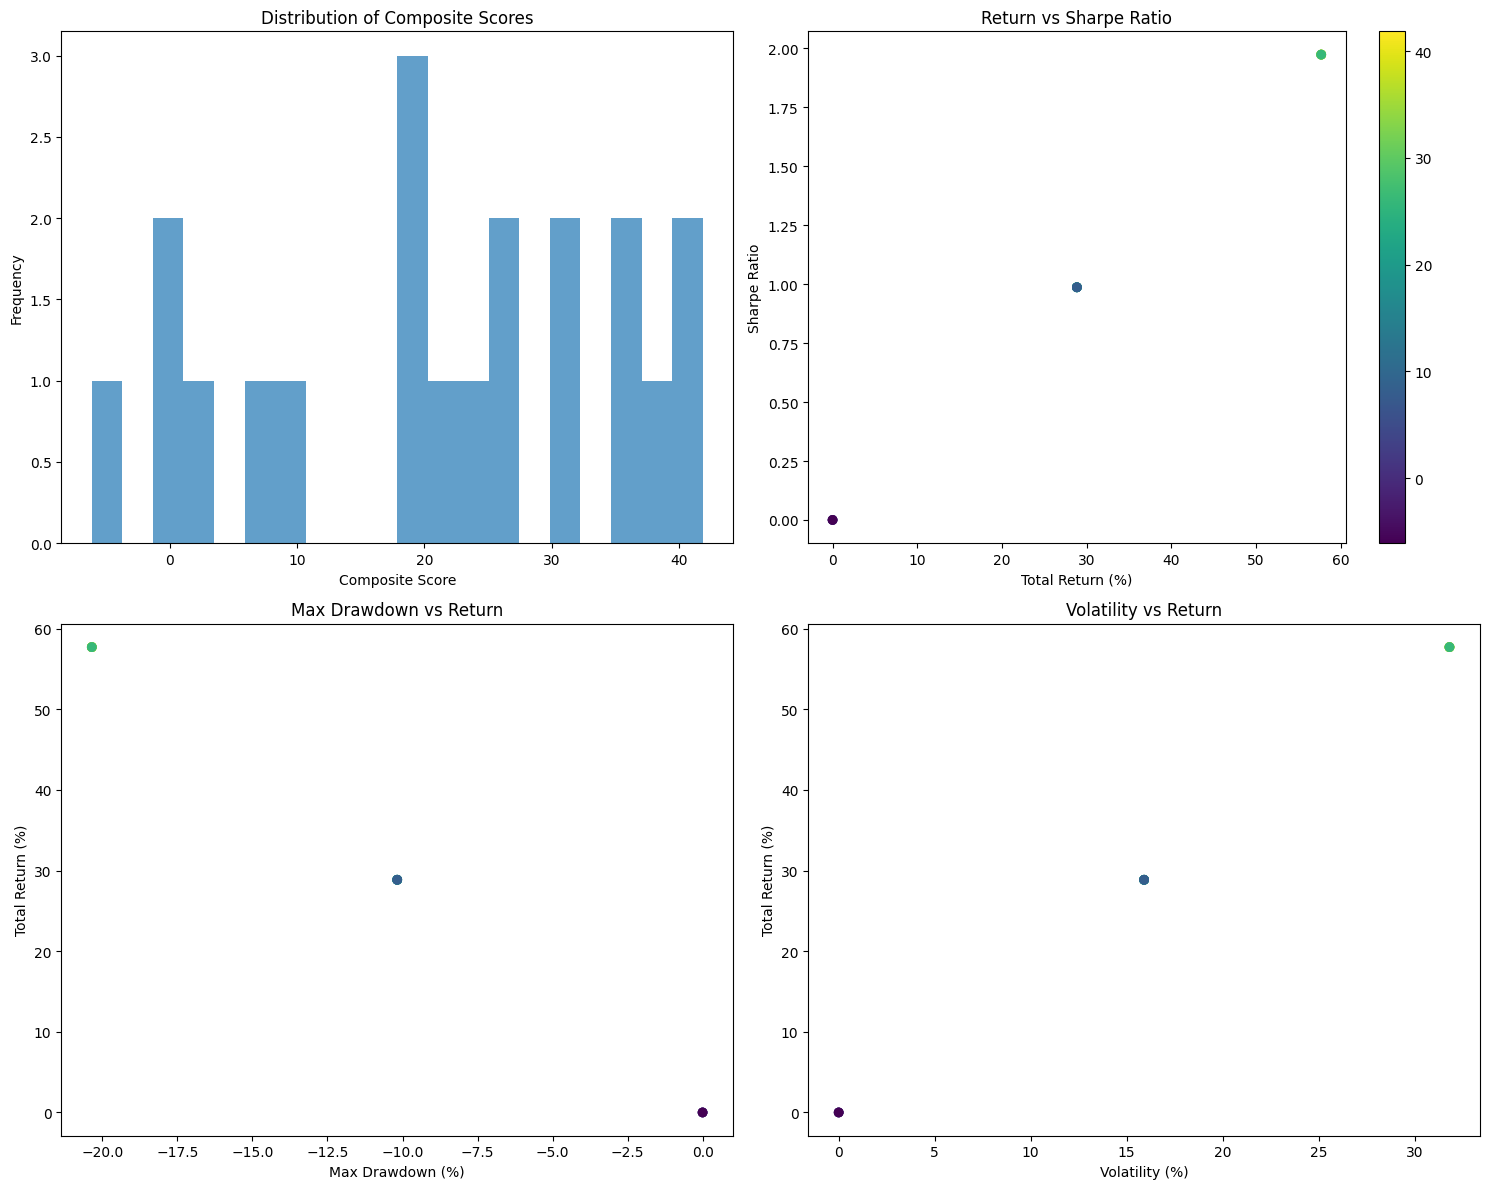

NameError: name 'datetime' is not defined

In [4]:

class HyperparameterOptimizer:
    """
    Comprehensive hyperparameter optimization for DRQN trading model
    """

    def __init__(self, df, initial_balance=10000, max_steps=200, n_trials=3):
        self.df = df
        self.initial_balance = initial_balance
        self.max_steps = max_steps
        self.n_trials = n_trials  # Number of trials per hyperparameter combination
        self.results = []

    def define_hyperparameter_space(self):
        """Define the hyperparameter search space"""
        hyperparams = {
            # Network architecture
            'hidden_dim': [64, 128, 256],
            'num_layers': [1, 2, 3],
            'dropout_rate': [0.1, 0.2, 0.3],

            # Training parameters
            'learning_rate': [1e-4, 1e-3, 1e-2],
            'batch_size': [16, 32, 64],
            'gamma': [0.95, 0.99, 0.999],

            # Exploration parameters
            'epsilon_start': [1.0],
            'epsilon_end': [0.01, 0.05, 0.1],
            'epsilon_decay': [200, 500, 1000],

            # Environment parameters
            'sequence_length': [5, 10, 20],
            'target_update': [5, 10, 20],

            # Replay buffer
            'buffer_capacity': [5000, 10000, 20000],

            # Technical indicators
            'window_sma': [10, 20, 30],
            'window_rsi': [14, 21, 28],
            'macd_fast': [12, 15, 18],
            'macd_slow': [26, 30, 34],
            'adx_period': [14, 20, 28]
        }

        return hyperparams

    def create_optimized_drqn(self, input_dim, action_dim, hidden_dim=128,
                            num_layers=2, dropout_rate=0.2):
        """Create DRQN with optimized architecture"""

        class OptimizedDRQN(nn.Module):
            def __init__(self, input_dim, action_dim, hidden_dim, num_layers, dropout_rate):
                super(OptimizedDRQN, self).__init__()
                self.hidden_dim = hidden_dim
                self.num_layers = num_layers

                # LSTM layer
                self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers,
                                  batch_first=True, dropout=dropout_rate if num_layers > 1 else 0)

                # Fully connected layers with layer normalization (works with single samples)
                self.fc1 = nn.Linear(hidden_dim, hidden_dim)
                self.ln1 = nn.LayerNorm(hidden_dim)
                self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
                self.ln2 = nn.LayerNorm(hidden_dim // 2)
                self.fc3 = nn.Linear(hidden_dim // 2, action_dim)

                self.dropout = nn.Dropout(dropout_rate)

            def forward(self, x, hidden=None):
                lstm_out, hidden = self.lstm(x, hidden)
                last_output = lstm_out[:, -1, :]

                x = torch.relu(self.ln1(self.fc1(last_output)))
                x = self.dropout(x)
                x = torch.relu(self.ln2(self.fc2(x)))
                x = self.fc3(x)

                return x, hidden

            def init_hidden(self, batch_size, device):
                h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
                c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
                return (h0, c0)

        return OptimizedDRQN(input_dim, action_dim, hidden_dim, num_layers, dropout_rate)

    def train_model(self, hyperparams, episode_count=50, verbose=False):
        """Train model with given hyperparameters"""

        # Prepare data with optimized indicators
        df_optimized = add_indicators(
            self.df.copy(),
            window_sma=hyperparams['window_sma'],
            window_rsi=hyperparams['window_rsi'],
            macd_fast=hyperparams['macd_fast'],
            macd_slow=hyperparams['macd_slow'],
            adx_period=hyperparams['adx_period']
        )

        # Create environment
        env = TradingEnv(
            df_optimized,
            initial_balance=self.initial_balance,
            max_steps=self.max_steps,
            sequence_length=hyperparams['sequence_length']
        )

        # Initialize networks
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        policy_net = self.create_optimized_drqn(
            env.observation_space.shape[0],
            env.action_space.n,
            hidden_dim=hyperparams['hidden_dim'],
            num_layers=hyperparams['num_layers'],
            dropout_rate=hyperparams['dropout_rate']
        ).to(device)

        target_net = self.create_optimized_drqn(
            env.observation_space.shape[0],
            env.action_space.n,
            hidden_dim=hyperparams['hidden_dim'],
            num_layers=hyperparams['num_layers'],
            dropout_rate=hyperparams['dropout_rate']
        ).to(device)

        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()

        optimizer = optim.Adam(policy_net.parameters(), lr=hyperparams['learning_rate'])
        memory = ReplayBuffer(capacity=hyperparams['buffer_capacity'])

        # Training parameters
        steps_done = 0
        episode_rewards = []

        def select_action(state):
            nonlocal steps_done
            eps_threshold = hyperparams['epsilon_end'] + \
                          (hyperparams['epsilon_start'] - hyperparams['epsilon_end']) * \
                          np.exp(-1. * steps_done / hyperparams['epsilon_decay'])
            steps_done += 1

            if random.random() < eps_threshold:
                return int(random.randrange(env.action_space.n))

            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                q_values, _ = policy_net(state_tensor)
                return int(q_values.argmax().item())

        # Training loop
        for episode in range(episode_count):
            state = env.reset()
            total_reward = 0

            for t in range(self.max_steps):
                action = select_action(state)
                next_state, reward, done, _ = env.step(int(action))
                memory.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                # Learn from experience
                if len(memory) >= hyperparams['batch_size']:
                    transitions = memory.sample(hyperparams['batch_size'])
                    batch = Transition(*zip(*transitions))

                    state_batch = torch.tensor(np.array(batch.state), dtype=torch.float32).to(device)
                    action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
                    reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
                    next_state_batch = torch.tensor(np.array(batch.next_state), dtype=torch.float32).to(device)
                    done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

                    q_values, _ = policy_net(state_batch)
                    q_values = q_values.gather(1, action_batch)

                    with torch.no_grad():
                        next_q_values, _ = target_net(next_state_batch)
                        next_q_values = next_q_values.max(1)[0].detach().unsqueeze(1)

                    expected_q = reward_batch + (hyperparams['gamma'] * next_q_values * (1 - done_batch))

                    loss = nn.MSELoss()(q_values, expected_q)
                    optimizer.zero_grad()
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
                    optimizer.step()

                if done:
                    break

            if episode % hyperparams['target_update'] == 0:
                target_net.load_state_dict(policy_net.state_dict())

            episode_rewards.append(total_reward)

            if verbose and episode % 10 == 0:
                print(f"Episode {episode}, Reward: {total_reward:.2f}")

        # Evaluation
        policy_net.eval()
        state = env.reset()
        portfolio_values = []

        for _ in range(env.max_steps):
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                q_values, _ = policy_net(state_tensor)
                action = int(q_values.argmax().item())

            state, _, done, _ = env.step(action)
            portfolio_values.append(env.net_worth)
            if done:
                break

        # Calculate metrics
        final_value = portfolio_values[-1]
        total_return = (final_value / self.initial_balance - 1) * 100

        # Calculate Sharpe ratio
        returns = np.diff(portfolio_values) / portfolio_values[:-1]
        sharpe_ratio = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)

        # Calculate maximum drawdown
        peak = np.maximum.accumulate(portfolio_values)
        drawdown = (portfolio_values - peak) / peak
        max_drawdown = np.min(drawdown) * 100

        # Calculate volatility
        volatility = np.std(returns) * np.sqrt(252) * 100

        # Average episode reward
        avg_episode_reward = np.mean(episode_rewards[-10:])  # Last 10 episodes

        return {
            'final_value': final_value,
            'total_return': total_return,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'volatility': volatility,
            'avg_episode_reward': avg_episode_reward,
            'portfolio_values': portfolio_values
        }

    def random_search(self, n_iterations=100, episode_count=50):
        """Perform random search optimization"""
        hyperparams = self.define_hyperparameter_space()

        print(f"Starting random search with {n_iterations} iterations...")
        print(f"Each configuration will be trained for {episode_count} episodes")
        print(f"Each configuration will be tested {self.n_trials} times")

        best_score = -np.inf
        best_hyperparams = None

        for iteration in range(n_iterations):
            # Sample random hyperparameters
            current_hyperparams = {}
            for param, values in hyperparams.items():
                if isinstance(values[0], (int, float)):
                    current_hyperparams[param] = values[np.random.randint(len(values))]
                else:
                    current_hyperparams[param] = np.random.choice(values)

            # Run multiple trials
            trial_results = []
            for trial in range(self.n_trials):
                try:
                    result = self.train_model(current_hyperparams, episode_count)
                    trial_results.append(result)
                except Exception as e:
                    print(f"Trial {trial + 1} failed: {e}")
                    continue

            if not trial_results:
                continue

            # Average results across trials
            avg_result = {}
            for key in trial_results[0].keys():
                if key != 'portfolio_values':
                    avg_result[key] = np.mean([r[key] for r in trial_results])

            # Calculate composite score (customize based on your preferences)
            score = (avg_result['total_return'] * 0.4 +
                    avg_result['sharpe_ratio'] * 20 * 0.3 +
                    -abs(avg_result['max_drawdown']) * 0.2 +
                    avg_result['avg_episode_reward'] * 0.1)

            avg_result['composite_score'] = score
            avg_result['hyperparameters'] = current_hyperparams
            self.results.append(avg_result)

            if score > best_score:
                best_score = score
                best_hyperparams = current_hyperparams.copy()

            print(f"Iteration {iteration + 1}/{n_iterations}")
            print(f"Return: {avg_result['total_return']:.2f}%, "
                  f"Sharpe: {avg_result['sharpe_ratio']:.3f}, "
                  f"Score: {score:.2f}")
            print(f"Best score so far: {best_score:.2f}")
            print("-" * 50)

        return best_hyperparams, best_score

    def grid_search(self, param_grid, episode_count=30):
        """Perform grid search on a subset of hyperparameters"""
        print(f"Starting grid search...")
        print(f"Grid size: {np.prod([len(v) for v in param_grid.values()])} combinations")

        # Use default values for parameters not in grid
        default_hyperparams = {
            'hidden_dim': 128, 'num_layers': 2, 'dropout_rate': 0.2,
            'learning_rate': 1e-3, 'batch_size': 32, 'gamma': 0.99,
            'epsilon_start': 1.0, 'epsilon_end': 0.01, 'epsilon_decay': 500,
            'sequence_length': 10, 'target_update': 10, 'buffer_capacity': 10000,
            'window_sma': 10, 'window_rsi': 14, 'macd_fast': 12,
            'macd_slow': 26, 'adx_period': 14
        }

        best_score = -np.inf
        best_hyperparams = None

        # Generate all combinations
        param_names = list(param_grid.keys())
        param_values = list(param_grid.values())

        for combination in product(*param_values):
            current_hyperparams = default_hyperparams.copy()
            for i, param_name in enumerate(param_names):
                current_hyperparams[param_name] = combination[i]

            # Run multiple trials
            trial_results = []
            for trial in range(self.n_trials):
                try:
                    result = self.train_model(current_hyperparams, episode_count)
                    trial_results.append(result)
                except Exception as e:
                    print(f"Trial {trial + 1} failed: {e}")
                    continue

            if not trial_results:
                continue

            # Average results
            avg_result = {}
            for key in trial_results[0].keys():
                if key != 'portfolio_values':
                    avg_result[key] = np.mean([r[key] for r in trial_results])

            # Calculate composite score
            score = (avg_result['total_return'] * 0.4 +
                    avg_result['sharpe_ratio'] * 20 * 0.3 +
                    -abs(avg_result['max_drawdown']) * 0.2 +
                    avg_result['avg_episode_reward'] * 0.1)

            avg_result['composite_score'] = score
            avg_result['hyperparameters'] = current_hyperparams
            self.results.append(avg_result)

            if score > best_score:
                best_score = score
                best_hyperparams = current_hyperparams.copy()

            print(f"Combination: {dict(zip(param_names, combination))}")
            print(f"Return: {avg_result['total_return']:.2f}%, "
                  f"Sharpe: {avg_result['sharpe_ratio']:.3f}, "
                  f"Score: {score:.2f}")
            print("-" * 50)

        return best_hyperparams, best_score

    def analyze_results(self):
        """Analyze and visualize optimization results"""
        if not self.results:
            print("No results to analyze. Run optimization first.")
            return

        df_results = pd.DataFrame(self.results)

        # Sort by composite score
        df_results = df_results.sort_values('composite_score', ascending=False)

        # Display top 10 results
        print("Top 10 Hyperparameter Combinations:")
        print("=" * 70)

        for i, row in df_results.head(10).iterrows():
            print(f"Rank {df_results.index.get_loc(i) + 1}:")
            print(f"  Score: {row['composite_score']:.3f}")
            print(f"  Return: {row['total_return']:.2f}%")
            print(f"  Sharpe: {row['sharpe_ratio']:.3f}")
            print(f"  Max Drawdown: {row['max_drawdown']:.2f}%")
            print(f"  Hyperparameters: {row['hyperparameters']}")
            print("-" * 70)

        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Score distribution
        axes[0, 0].hist(df_results['composite_score'], bins=20, alpha=0.7)
        axes[0, 0].set_title('Distribution of Composite Scores')
        axes[0, 0].set_xlabel('Composite Score')
        axes[0, 0].set_ylabel('Frequency')

        # Return vs Sharpe ratio
        scatter = axes[0, 1].scatter(df_results['total_return'], df_results['sharpe_ratio'],
                                   c=df_results['composite_score'], cmap='viridis')
        axes[0, 1].set_xlabel('Total Return (%)')
        axes[0, 1].set_ylabel('Sharpe Ratio')
        axes[0, 1].set_title('Return vs Sharpe Ratio')
        plt.colorbar(scatter, ax=axes[0, 1])

        # Max drawdown vs return
        axes[1, 0].scatter(df_results['max_drawdown'], df_results['total_return'],
                          c=df_results['composite_score'], cmap='viridis')
        axes[1, 0].set_xlabel('Max Drawdown (%)')
        axes[1, 0].set_ylabel('Total Return (%)')
        axes[1, 0].set_title('Max Drawdown vs Return')

        # Volatility vs return
        axes[1, 1].scatter(df_results['volatility'], df_results['total_return'],
                          c=df_results['composite_score'], cmap='viridis')
        axes[1, 1].set_xlabel('Volatility (%)')
        axes[1, 1].set_ylabel('Total Return (%)')
        axes[1, 1].set_title('Volatility vs Return')

        plt.tight_layout()
        plt.show()

        return df_results

    def save_results(self, filename=None):
        """Save optimization results to file"""
        if filename is None:
            filename = f"hyperopt_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"

        # Convert results to JSON-serializable format
        serializable_results = []
        for result in self.results:
            serializable_result = result.copy()
            # Remove portfolio_values as it's not JSON serializable
            if 'portfolio_values' in serializable_result:
                del serializable_result['portfolio_values']
            serializable_results.append(serializable_result)

        with open(filename, 'w') as f:
            json.dump(serializable_results, f, indent=2)

        print(f"Results saved to {filename}")


# Example usage
if __name__ == "__main__":
    # Fetch and prepare data
    df = fetch_data('AAPL', '2020-01-01', '2021-01-01')

    # Initialize optimizer
    optimizer = HyperparameterOptimizer(df, n_trials=2)  # Reduced for faster testing

    # Option 1: Random search (recommended for initial exploration)
    print("Starting random search optimization...")
    best_hyperparams, best_score = optimizer.random_search(
        n_iterations=20,  # Increase for more thorough search
        episode_count=30   # Reduce for faster testing
    )

    print(f"\nBest hyperparameters found:")
    print(f"Score: {best_score:.3f}")
    print(f"Parameters: {best_hyperparams}")

    # Option 2: Grid search (for fine-tuning specific parameters)
    """
    grid_params = {
        'learning_rate': [1e-4, 1e-3, 1e-2],
        'hidden_dim': [64, 128, 256],
        'sequence_length': [5, 10, 15]
    }

    print("\nStarting grid search optimization...")
    best_hyperparams_grid, best_score_grid = optimizer.grid_search(
        grid_params,
        episode_count=20
    )
    """

    # Analyze results
    results_df = optimizer.analyze_results()

    # Save results
    optimizer.save_results()

    print("\nOptimization complete!")